# Install

- keras >= 3.0.0
- standard keras python whatever stuff

# Run

run the notebook from top down

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["KERAS_BACKEND"] = "torch"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from classes import *
import keras
from keras import ops
import matplotlib.pyplot as plt
import numpy as np
def length(x, t = 0.01):
    return ops.max(ops.where(x>t)[0])

/home/bergerdd/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading the dataset

In [3]:
# dataset is located in data/dataset_medium_k_3e-10_1000dp inputs_gksi
inputs, outputs = load_dataset("dataset_medium_k_3e-10_1000dp inputs_gksi", inputs_map = lambda x: x[:2])
# input is: pressure gradient, permeability, sdf, material_id
# inputs_map is applied to each datapoint separately, so you only get pressure gradient and permeability
coordinate_origin = (31,21) # from info.yaml
n, height, width, _ = outputs.shape

# get coordinates in ([0,1]² - coordinate_origin/(height,width)), so that origin is at (0,0)
coords = coordinates(height,width, coordinate_origin)
# coords shape is (height, width, 2)

# coords are the same for each sample, so we repeat them n times and add them to the inputs
repeat_coords = ops.repeat(coords[None,...], n, axis = 0)
inputs = ops.concatenate((inputs,repeat_coords), axis = -1)

# get the length of each heat plume (length is distance to where normalized temperature is less than t=0.01)
lengths = ops.convert_to_tensor([length(sample[...,0], t = 0.01) for sample in outputs])

# split train and val
split = 0.95
n_train = int(n*split)

max_length = 400
small_samples = ops.where(lengths < max_length)[0]
long_samples = ops.where(lengths >= max_length)[0]

# only train on the first max_length cells (y direction)
inputs_train = inputs[:n_train, :max_length]
outputs_train = outputs[:n_train, :max_length]

# validate on the entire sample
inputs_val = inputs[n_train:]
outputs_val = outputs[n_train:]

# flatten inputs and outputs, the network maps [P,K,x,y] -> [T]
flat_inputs_train = ops.reshape(inputs_train, (-1, 4))
flat_outputs_train = ops.reshape(outputs_train, (-1, 1))
flat_inputs_val = ops.reshape(inputs_val, (-1, 4))
flat_outputs_val = ops.reshape(outputs_val, (-1, 1))

print(f"{inputs.shape=}, {outputs.shape=}")
print(f"{flat_inputs_train.shape=}, {flat_outputs_train.shape=}")
print(f"{flat_inputs_val.shape=}, {flat_outputs_val.shape=}")

  0%|          | 0/998 [00:00<?, ?it/s]

100%|██████████| 998/998 [00:02<00:00, 403.87it/s]


small_samples.shape=torch.Size([733]), long_samples.shape=torch.Size([265])
inputs.shape=torch.Size([998, 1280, 64, 4]), outputs.shape=torch.Size([998, 1280, 64, 1])
flat_inputs_train.shape=torch.Size([24268800, 4]), flat_outputs_train.shape=torch.Size([24268800, 1])
flat_inputs_val.shape=torch.Size([4096000, 4]), flat_outputs_val.shape=torch.Size([4096000, 1])


In [5]:
# get pressures and permeabilities for each sample
length_inputs_train = ops.convert_to_tensor([sample[0,0,:2] for sample in inputs_train])
length_inputs_val = ops.convert_to_tensor([sample[0,0,:2] for sample in inputs_val])

# normalize lengths
length_outputs_train = (lengths[:n_train] - 31 )/height
length_outputs_val = (lengths[n_train:]-31) /height

# Length model

First, train a length model that predicts the length of a heatplume from pressure and permeability alone. This model's output is used in the full model with training disabled.

This needs further ablation

In [6]:
length_model = keras.models.Sequential([
    keras.layers.Input(shape= (2,)),
    keras.layers.Dense(16, activation = "relu"),
    keras.layers.Dense(8, activation = "relu"),
    keras.layers.Dense(1, activation =None),
])
length_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193 (772.00 B)

 Trainable params: 193 (772.00 B)

 Non-trainable params: 0 (0.00 B)

In [7]:
length_model.compile(optimizer = keras.optimizers.Adam(learning_rate = 3e-4), loss = "mse")

`CustiomTensorboard` logs to the given directory and creates a new directory for each run named by the current time.

In [ ]:
length_model.fit(
    length_inputs_train,
    length_outputs_train,
    epochs=1000,
    batch_size=32,
    shuffle = True,
    validation_data = (length_inputs_val, length_outputs_val),
    callbacks=[
          CustomTensorboard("logs/length")],
    verbose=0,
)

In [136]:
length_model.save("length_model.keras")

In [9]:
# Simple layer to use the length model in a Sequential model, it appends the length to the input
class AddLength(keras.layers.Layer):
    def __init__(self, length_model):
        super().__init__()
        self.length_model = length_model
        self.length_model.trainable = False
    def call(self, inputs):
        return ops.concatenate([inputs, self.length_model(inputs[...,:2])], axis = -1)
    def get_config(self):
        return {"length_model":self.length_model}
    def from_config(self, config):
        return AddLength(**config)

leaky relu in the last layer of the following model is a tradeoff:
- real relu would be perfect, because it would make it incredibly easy for the model to have output zero temperature outside the heatplumes
- relu can die in early training, so we use leaky relu to prevent that
- maybe exchange last layer activation with relu after (pre-)training?

In [32]:
model = keras.Sequential(
    [
        keras.layers.Input(shape= (4,)),
        AddLength(length_model),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dense(1, activation="leaky_relu")
    ],
)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ add_length_1 (AddLength)        │ (None, 5)              │           193 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,778 (264.76 KB)

 Trainable params: 67,585 (264.00 KB)

 Non-trainable params: 193 (772.00 B)

In [ ]:
# maybe train this twice?
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4, weight_decay=0.001), loss="mse"
)
model.fit(
    flat_inputs_train,
    flat_outputs_train,
    epochs=10,
    batch_size=10000,
    shuffle = True,
    validation_data = (flat_inputs_val, flat_outputs_val),
    callbacks=[
          CustomTensorboard("logs/extend")],
    verbose=1,
)

In [36]:
model.save("extended_with_length.keras")

# Evaluation

Look at random validation samples and the model's predictions for them.

Index 14 is a good example of a long heatplume

Use Ctrl + Alt + Enter to run the cell quickly without the screen moving

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


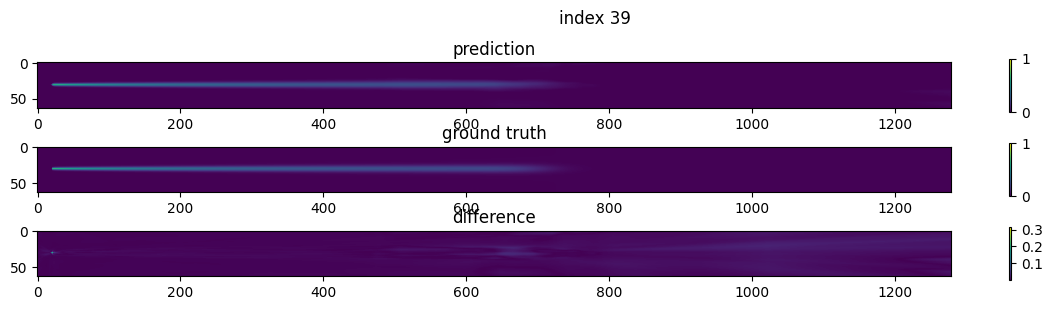

In [61]:
# TODO fix colorbars
index = np.random.randint(0,inputs_val.shape[0])
# index = 14
result = model.predict(inputs_val[index:index+1].reshape(-1,4),batch_size = 100000)
result = result.reshape(height,width)[:].T
gt = outputs_val[index,:,:,0].cpu().numpy().T
plt.figure(figsize = (12,3))
plt.suptitle(f"index {index}")
plt.subplot(3,1,1)
plt.title("prediction")
plt.imshow(result, vmin = 0, vmax = 1)
plt.colorbar()
plt.subplot(3,1,2)
plt.title("ground truth")
plt.imshow(gt, vmin = 0, vmax = 1)
plt.colorbar()
plt.subplot(3,1,3)
plt.title("difference")
plt.imshow(np.abs(result-gt))
plt.colorbar()
plt.tight_layout()
plt.show()